In [107]:
##DS 8014 Graph Mining Assignment 6

##Gorkem Sarp; Richa Sharma

##Question 1 and 2

In [ ]:
!pip install python-igraph
!pip install umap-learn
!pip install sklearn
!pip install partition_igraph
!pip install python-igraph leidenalg cairocffi
!pip install big-o
!pip install --no-dependencies graphrole

In [109]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
import scipy.sparse.linalg as lg
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_mutual_info_score as AMI
from graphrole import RecursiveFeatureExtractor, RoleExtractor
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import calinski_harabasz_score as CHS
from sklearn.metrics import silhouette_score as SIL
%config Completer.use_jedi = False

## node and edge greyscale colors
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [110]:
cmd = 'julia '+abcd_path+'install.jl'
os.system(cmd)

0

In [111]:
!curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.2/julia-1.2.0-linux-x86_64.tar.gz" -o julia.tar.gz
!tar -xzf julia.tar.gz -C /usr --strip-components 1
!rm -rf julia.tar.gz*
!julia -e 'using Pkg; pkg"add IJulia; precompile"'
!echo "DONE"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
Precompiling project...
DONE


In [112]:
!julia Datasets/ABCD/utils/install.jl

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/bkamins/ABCDGraphGenerator.jl`
  Updating git-repo `https://github.com/bkamins/ABCDGraphGenerator.jl`
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [113]:
!python src/main.py

Traceback (most recent call last):
  File "src/main.py", line 15, in <module>
    import node2vec
  File "/content/src/node2vec.py", line 46
    print 'Walk iteration:'
                          ^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print('Walk iteration:')?


In [114]:
## the data directory
datadir = 'Datasets/'
abcd_path = datadir+'ABCD/utils/'
## location of the GED code
## use the '-S' option to use split JS divergence
GED = './GED'

## location of the node2vec code
n2v = '~/node2vec/node2vec'

In [115]:
%%bash
gcc GED.c -o GED -lm -O3

GED.c: In function ‘main’:
GED.c:271:3: warning: ignoring return value of ‘fscanf’, declared with attribute warn_unused_result [-Wunused-result]
   fscanf(fp,"%d %d",&j,&dim);
   ^~~~~~~~~~~~~~~~~~~~~~~~~~


In [116]:
## as defined in the node2vec paper
def binary_operator(u, v, op='had'):
    if op=='had':
        return u * v
    if op=='l1':
        return np.abs(u - v)
    if op=='l2':
        return (u - v) ** 2
    if op=='avg':
        return (u + v) / 2.0
    
def readEmbedding(fn="_embed", N2K=None):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    if N2K!=None:
        x = [N2K[i] for i in D[0]]
        D[0] = x    
        D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    return Y

## Read embedding from file in node2vec format
## Map to layout format
## for visualization, we use UMAP if dim > 2
def embed2layout(fn="_embed"):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    if Y.shape[1]>2:
        Y = umap.UMAP().fit_transform(Y)
    ly = []
    for v in range(Y.shape[0]):
        ly.append((Y[v][0],Y[v][1]))
    return ly


## Computing JS divergence with GED code given edgelist, communities and embedding
def JS(edge_file, comm_file, embed_file, entropy=False):
    if entropy:
        x = GED+' -E -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    else:
        x = GED+' -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    s = subprocess.run(x, shell=True, stdout=subprocess.PIPE)
    x = s.stdout.decode().split(' ')
    #for id in x:
      #print(id)
    div = float(x[1])
    return(div)


## save to disk to compute divergence
def saveEmbedding(X, g, fn='_embed'):
    with open(fn,'w') as f:
        f.write(str(X.shape[0]) + " " + str(X.shape[1])+'\n')
        for i in range(X.shape[0]):
            f.write(g.vs[i]['name']+' ')
            for j in range(X.shape[1]):
                f.write(str(X[i][j])+' ')
            f.write('\n')

## Laplacian eigenmaps embedding
def LE(g, dim=2):
    L_sym = np.array(g.laplacian(normalized=True))
    w, v = lg.eigs(L_sym, k=dim + 1, which='SM')
    idx = np.argsort(w) # sort eigenvalues
    w = w[idx]
    v = v[:, idx]
    X = v[:, 1:]
    return X.real

def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [117]:
#Part A

In [118]:
#File configuration for generating ABCD graph
#seed = "42"                   # RNG seed, use "" for no seeding
#n = "1000"                   # number of vertices in graph
#t1 = "2.5"                      # power-law exponent for degree distribution
#d_min = "5"                   # minimum degree
#d_max = "50"                  # maximum degree
#d_max_iter = "1000"           # maximum number of iterations for sampling degrees
#t2 = "1.5"                      # power-law exponent for cluster size distribution
#c_min = "50"                  # minimum cluster size
#c_max = "1000"                # maximum cluster size
#c_max_iter = "1000"           # maximum number of iterations for sampling cluster sizes
# Exactly one of xi and mu must be passed as Float64. Also if xi is provided islocal must be set to false or omitted.
#xi = "0.2"                    # fraction of edges to fall in background graph
#mu = "0.2"                   # mixing parameter
#islocal = "false"             # if "true" mixing parameter is restricted to local cluster, otherwise it is global
#isCL = "false"                # if "false" use configuration model, if "true" use Chung-Lu
#degreefile = "newdeg.dat"        # name of file do generate that contains vertex degrees
#communitysizesfile = "newcs.dat" # name of file do generate that contains community sizes
#communityfile = "newcom.dat"     # name of file do generate that contains assignments of vertices to communities
#networkfile = "newedge.dat"      # name of file do generate that contains edges of the generated graph

In [119]:
print("In the above code, n is 1000, gamma is 2.5, beta is 1.5, xsi is 0.2")

In the above code, n is 1000, gamma is 2.5, beta is 1.5, xsi is 0.2


In [120]:
print("Following command was used in command prompt for ABCD graph files: julia abcd_sampler.jl config2.toml")

Following command was used in command prompt for ABCD graph files: julia abcd_sampler.jl config2.toml


In [121]:
print("We manually converted newcom.dat generated from above command into clusters_file for GED (.ecg file), \njust removed the first column in newcom.dat in Excel")

We manually converted newcom.dat generated from above command into clusters_file for GED (.ecg file), 
just removed the first column in newcom.dat in Excel


In [122]:
## read graph and communities
new_graph = ig.Graph.Read_Ncol("newedge.dat",directed=False)
new_com = np.loadtxt("newcom.dat",dtype='uint16',usecols=(1))

1000 vertices, 5074 edges, avg degreee 10.148 communities 25


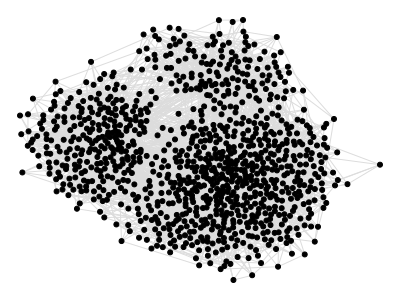

In [123]:
new_graph.vs['comm'] = [c[int(x['name'])-1] for x in new_graph.vs]
## print a few stats
print(new_graph.vcount(),'vertices,',new_graph.ecount(),'edges,','avg degreee',np.mean(new_graph.degree()),'communities',max(G.vs['comm']))
## ground truth
GT = {k:(v-1) for k,v in enumerate(new_graph.vs['comm'])}
## map between int(name) to key
N2K = {int(v):k for k,v in enumerate(new_graph.vs['name'])}
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
new_graph.vs['size'] = 5
new_graph.es['color'] = cls_edges
new_graph.vs['color'] = 'black'
ig.plot(new_graph, bbox=(0,0,400,300)) ## communities are far from obvious in 2d layout!



In [124]:
results = [] #results
DIM = [4,8,16,32,64,128] #dimensions
best_jsd = 1
worst_jsd = 0

REP = 30 #repetitions

for rept in range(REP):

  ## node2vec for probabilistic / non-deterministic embedding
  for dim in DIM:
      for (p,q) in [(1,0.1),(1,.5),(0.1,1),(.5,1),(1,1)]:
          ## long walks:
          #x = n2v + ' -i:'+datadir+'ABCD/abcd_100.dat -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
          ## short walks:
          x = n2v + ' -l:30 -i:newedge.dat -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
          r = os.system(x+' >/dev/null 2>&1')
          jsd = JS('newedge.dat','newcomecgversion2.ecg','_embed')
          ## keep track of best and worst
          if jsd < best_jsd:
              os.system('cp _embed _embed_best')
              best_jsd = jsd
          if jsd > worst_jsd:
              os.system('cp _embed _embed_worst')
              worst_jsd = jsd
          results.append([rept, dim,'n2v',str(p)+' '+str(q),jsd])



  ## Laplacian eigenmaps embedding, deterministic embedding
  for dim in DIM:
      X = LE(G,dim=dim)
      saveEmbedding(X,G)
      jsd = JS('newedge.dat','newcomecgversion2.ecg','_embed')
      ## keep track of best and worst
      if jsd < best_jsd:
          os.system('cp _embed _embed_best')
          best_jsd = jsd
      if jsd > worst_jsd:
          os.system('cp _embed _embed_worst')
          worst_jsd = jsd
      results.append([rept, dim,'le',' ',jsd])



In [125]:
#Part B

In [126]:
results_df = pd.DataFrame(results,columns=['repetition','dim','algo','param','jsd'])
results_df = results_df.sort_values(by='jsd',axis=0)
results_df.head()

,repetition,dim,algo,param,jsd
1038,28,4,le,,0.133125
102,2,4,le,,0.133125
858,23,4,le,,0.133125
570,15,4,le,,0.133125
138,3,4,le,,0.133125


In [127]:
results_df.tail()



,repetition,dim,algo,param,jsd
140,3,16,le,,0.133298
176,4,16,le,,0.133298
716,19,16,le,,0.133298
644,17,16,le,,0.133298
320,8,16,le,,0.133298


In [128]:
results_df.groupby(['algo']).head()

,repetition,dim,algo,param,jsd
1038,28,4,le,,0.133125
102,2,4,le,,0.133125
858,23,4,le,,0.133125
570,15,4,le,,0.133125
138,3,4,le,,0.133125
727,20,8,n2v,0.1 1,0.133279
728,20,8,n2v,0.5 1,0.133279
741,20,64,n2v,1 0.5,0.133279
729,20,8,n2v,1 1,0.133279
569,15,128,n2v,1 1,0.133279


In [129]:
results_df.groupby(['algo']).tail()

,repetition,dim,algo,param,jsd
365,10,8,n2v,1 0.1,0.133279
378,10,32,n2v,0.5 1,0.133279
396,11,4,n2v,1 0.1,0.133279
367,10,8,n2v,0.1 1,0.133279
366,10,8,n2v,1 0.5,0.133279
140,3,16,le,,0.133298
176,4,16,le,,0.133298
716,19,16,le,,0.133298
644,17,16,le,,0.133298
320,8,16,le,,0.133298


In [130]:
results_df.sort_values(by=['jsd'])

,repetition,dim,algo,param,jsd
1038,28,4,le,,0.133125
1074,29,4,le,,0.133125
750,20,4,le,,0.133125
462,12,4,le,,0.133125
1002,27,4,le,,0.133125
...,...,...,...,...,...
284,7,16,le,,0.133298
1076,29,16,le,,0.133298
644,17,16,le,,0.133298
32,0,16,le,,0.133298


In [145]:
print("Lower divergence score means better embedding. The lowest divergence is for \nLaplacian eigenmaps embedding, with 4 dimensions. \nAll divergence scores look close however. The most stable is node2vec ")

Lower divergence score means better embedding. The lowest divergence is for 
Laplacian eigenmaps embedding, with 4 dimensions. 
All divergence scores look close however. The most stable is node2vec 


In [132]:
#Part C

In [133]:
#mean
results_df.groupby(['algo', 'dim']).mean()

repetition       jsd
algo dim                      
le   4          14.5  0.133125
     8          14.5  0.133246
     16         14.5  0.133298
     32         14.5  0.133290
     64         14.5  0.133276
     128        14.5  0.133279
n2v  4          14.5  0.133279
     8          14.5  0.133279
     16         14.5  0.133279
     32         14.5  0.133279
     64         14.5  0.133279
     128        14.5  0.133279

In [134]:
#standard deviation
results_df.groupby(['algo', 'dim']).std(ddof=0)

repetition  jsd
algo dim                 
le   4      8.655441  0.0
     8      8.655441  0.0
     16     8.655441  0.0
     32     8.655441  0.0
     64     8.655441  0.0
     128    8.655441  0.0
n2v  4      8.655441  0.0
     8      8.655441  0.0
     16     8.655441  0.0
     32     8.655441  0.0
     64     8.655441  0.0
     128    8.655441  0.0

In [143]:
print("Note that standard deviation is very small or 0")

Note that standard deviation is very small or 0


In [136]:
##Question 2

In [137]:
from sklearn.metrics import adjusted_rand_score as ARI

In [138]:
## ground truth
ground_truth = {k:(v-1) for k,v in enumerate(new_graph.vs['comm'])}
print('number of communities are:',np.max(list(ground_truth.values()))+1)

number of communities are: 25


In [141]:
#K Means
#25 communities for ground truth

#best is LE with 4 dimensions
X = LE(G,dim=4)
cl = KMeans(n_clusters=25).fit(X)
d = {k:v for k,v in enumerate(cl.labels_)}
scr = CHS(X,cl.labels_)
ami = AMI(list(ground_truth.values()),list(d.values()))
ari = ARI(list(ground_truth.values()),list(d.values()))
agri=G.gam(ground_truth,d)
print("AMI for best embedding, which is LE with 4 dimensions: ", ami)
print("ARI for best embedding, which is LE with 4 dimensions: ", ari)
print("AGRI for best embedding, which is LE with 4 dimensions: ", agri)

AMI for best embedding, which is LE with 4 dimensions:  0.009225123384105364
ARI for best embedding, which is LE with 4 dimensions:  0.001423211168272806
AGRI for best embedding, which is LE with 4 dimensions:  0.00016569836244673843


In [144]:
#worst is LE with 16 dimensions
X = LE(G,dim=16)
cl = KMeans(n_clusters=25).fit(X)
d = {k:v for k,v in enumerate(cl.labels_)}
scr = CHS(X,cl.labels_)
ami2 = AMI(list(ground_truth.values()),list(d.values()))
ari2 = ARI(list(ground_truth.values()),list(d.values()))
agri2=G.gam(ground_truth,d)
print("AMI for worst embedding, which is LE with 4 dimensions: ", ami2)
print("ARI for worst embedding, which is LE with 4 dimensions: ", ari2)
print("AGRI for worst embedding, which is LE with 4 dimensions: ", agri2)

AMI for worst embedding, which is LE with 4 dimensions:  0.010425759368667572
ARI for worst embedding, which is LE with 4 dimensions:  0.002295588802817267
AGRI for worst embedding, which is LE with 4 dimensions:  0.0029163930828106084


In [148]:
print("Given the very low AMI and ARI scores, the quality of embeddings seem very low. Partitions are far from \nbeing identical. However these results are very different from our lab, \nso it is possible we made a mistake somewhere")

Given the very low AMI and ARI scores, the quality of embeddings seem very low. Partitions are far from 
being identical. However these results are very different from our lab, 
so it is possible we made a mistake somewhere
